# Target Expression Analysis by Disease Type 

In [7]:
library(FirebrowseR)
library(dplyr)
library(hash)
library(reshape2)
library(ggplot2)

cohorts = Metadata.Cohorts(format = "tsv") # Download all available cohorts
h1<-hash(cohorts$cohort,cohorts$description)
#table <- c(())
for (type_of_cancer in ls(h1)[-c(10,15,18)]){
  cancer.Type = cohorts[grep(h1[[type_of_cancer]], cohorts$description, ignore.case = T), 1]
  #print(cancer.Type)
  cancer.Pats = Samples.Clinical(cohort = cancer.Type, format="tsv")
  #dim(brca.Pats)

  diff.Exp.Genes = c("PDCD1","CD274")


  all.Found = F
  page.Counter = 1
  mRNA.Exp = list()
  page.Size = 2000 # using a bigger page size is faster
  while(all.Found == F){
    mRNA.Exp[[page.Counter]] = Samples.mRNASeq(format = "csv",
                                             gene = diff.Exp.Genes,
                                             cohort = type_of_cancer,
                                             tcga_participant_barcode =
                                               cancer.Pats$tcga_participant_barcode,
                                             page_size = page.Size,
                                             page = page.Counter)
    if(nrow(mRNA.Exp[[page.Counter]]) < page.Size)
      all.Found = T
    else
      page.Counter = page.Counter + 1
   }
   mRNA.Exp = do.call(rbind, mRNA.Exp)
   dim(mRNA.Exp)

   Solid.Tumor.Pats = which(mRNA.Exp$sample_type == "TP")
# get the patients barcodes
   patient.Barcodes = mRNA.Exp$tcga_participant_barcode[Solid.Tumor.Pats]
# Subset the mRNA.Exp data frame, keeping only the pre-selected barcodes AND
# having a sample type of NT or TP
   mRNA.Exp = mRNA.Exp[which(mRNA.Exp$tcga_participant_barcode %in% patient.Barcodes &
                            mRNA.Exp$sample_type %in%  "TP"), ]
   mRNA.Exp <- filter(mRNA.Exp, expression_log2 != "None")
   cast_expression <- as.data.frame(dcast(mRNA.Exp[,1:3],tcga_participant_barcode~gene))
   cast_expression <- transform(cast_expression, CD274  = as.numeric(CD274 ),PDCD1=as.numeric(PDCD1))
   cast_expression$CD274_PDCD1 <- cast_expression$CD274+cast_expression$PDCD1
   
   PDCD1_median<-median(as.numeric(mRNA.Exp$expression_log2[mRNA.Exp$gene == "PDCD1"]))
   CD274_median<-median(as.numeric(mRNA.Exp$expression_log2[mRNA.Exp$gene == "CD274"]))
   CD274_PDCD1_median <- median(na.omit(cast_expression$CD274_PDCD1))
   if(type_of_cancer == "ACC"){
    tab <- cbind(PDCD1_median,CD274_median,CD274_PDCD1_median)
   }else{
  row <- cbind(PDCD1_median,CD274_median,CD274_PDCD1_median)
  tab <- rbind(tab,row)
}
   
}
rownames(tab)<-ls(h1)[-c(10,15,18)]
tab <- as.data.frame(tab)
tab[order(tab$CD274_PDCD1_median,decreasing = T),]

Using expression_log2 as value column: use value.var to override.
Using expression_log2 as value column: use value.var to override.
Using expression_log2 as value column: use value.var to override.
Using expression_log2 as value column: use value.var to override.
Using expression_log2 as value column: use value.var to override.
Using expression_log2 as value column: use value.var to override.
Using expression_log2 as value column: use value.var to override.
Using expression_log2 as value column: use value.var to override.
Using expression_log2 as value column: use value.var to override.
Using expression_log2 as value column: use value.var to override.
Using expression_log2 as value column: use value.var to override.
Using expression_log2 as value column: use value.var to override.
Using expression_log2 as value column: use value.var to override.
Using expression_log2 as value column: use value.var to override.
Using expression_log2 as value column: use value.var to override.
Using expr

,PDCD1_median,CD274_median,CD274_PDCD1_median
DLBC,8.895776,6.031766,15.614826
THYM,8.313108,6.686288,14.642833
TGCT,6.819986,4.699921,11.907354
LUAD,5.886576,6.004383,11.754746
HNSC,5.452554,6.332808,11.629748
LUSC,5.377683,6.110868,11.611263
CESC,5.681512,5.558419,11.328870
KIRC,5.822852,5.467932,10.848145
STAD,5.631602,5.052229,10.701275
STES,5.246005,5.257595,10.608163


Warning message:
“Removed 2 rows containing missing values (geom_point).”

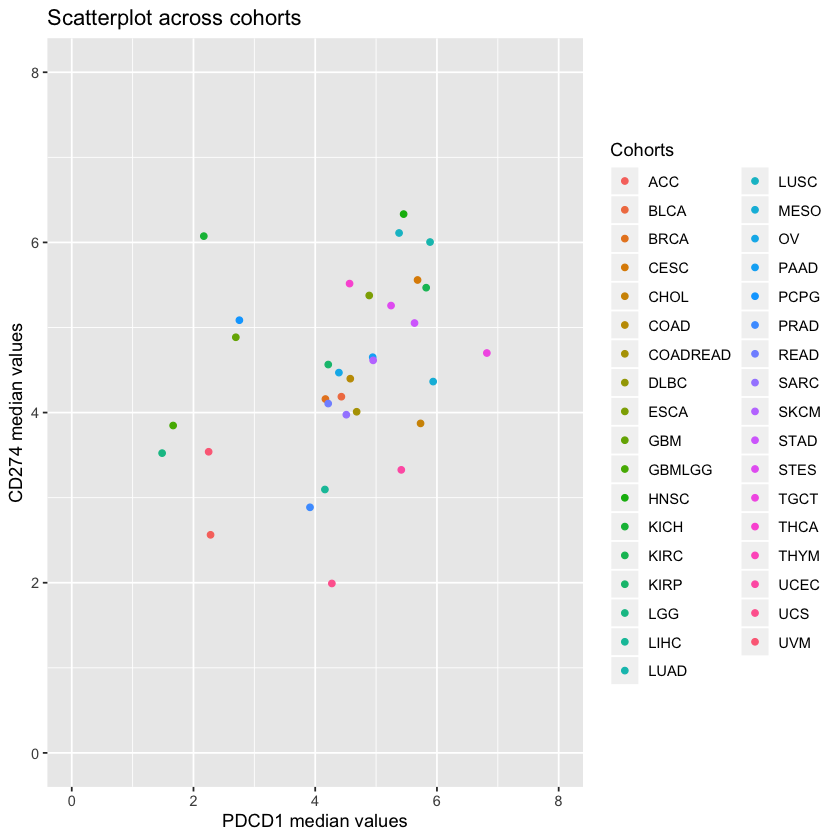

In [8]:
quartz()
ggplot(data=tab)+geom_point(aes(x=PDCD1_median,y=CD274_median,color=rownames(tab)))+
  ggtitle("Scatterplot across cohorts") + xlim(0,8) + ylim(0,8)+
    scale_shape_manual(values=1:35)+labs(x="PDCD1 median values",y="CD274 median values", color = "Cohorts")